# Background

Breast cancer is an uncontrolled growth of cells in the breast. It is the 2nd most common cancer in women and can even also on condition affect man as well. Breast is also the 2nd leading cause death cancer in women after lung cancer. Fine needle aspiration is one commonly used ICT diagnosis methods of breast cancer. By insert the needle in the breast to get the photo of the breast cell. From the photo of begline and malignant cell we can see they are differient in radius, area, roughness, density etc. so we believe those features can classify the cells into benign or malignant by those features.

# Hypothesis

We hypothesize that Machine Learning algorithms can predict the nature of a breast tumour (benign or malignant) in order to provide health sector with assistance to breast tumour classification.

Same methodology could be applied to other similar kind of cancer detection.

# Dataset

We collect the raw dataset on Kaggle https://www.kaggle.com/uciml/breast-cancer-wisconsin-data consisting in data samples about breast cells. For each cell, we have 10 main features: 
- radius 
- texture 
- perimeter 
- area 
- smoothness 
- compactness 
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension

For each feature we have three different values:
- its mean
- its standard error
- its _worst value_ (the mean of the three largest values)

resulting in total of 30 features for each cell sample. 

# Methodology summary
## Are we dealing with classification or regression?
This is a binary classification problem since the prediction task is to classify the observations in a set of finite labels - benign or malignant.

## Data exploration
We show some histograms to see the distribution of malignant cells under each feature, mainly to check if it's normal distribution and also a way to check if we need to delete any features or not. 

## Data formatting and data preparation
Then we do normalization of our dataset to make columns similar intrinsic influence on analytical model. Here are three ways of normalization:
- simple feature scaling
- min-max scaling
- Z-score scaling. 

We choose the second option: min-max scaling.

We saperate our dataset 80% for training data and 20% for testing data, and within training data we set 5 groups for cross-validation.

## Evaluating whether the dataset is linearly separable
We evaluate whether our data is linearly separable or not. The concept of linear separability applies to binary datasets. Since our dataset is a binary dataset (diagnosis: M = malignant, B = benign) it makes sense to consider if our data is linearly separable or not.

## Testing different ML algorithms

We run different machine learning algorithms:

- SVM classifier (with linear kernel, polynomial kernels and RBF kernel)
- MLP classifier 
- k-Nearest Neighbour
- Decision Tree
- Logistic Regression

## Algorithms accuracy evaluation 
The results are reported as the accuracy of each classifier, and we calculate this accuracy using different evaluation metrics: 

- Jaccard index
- F1-score

# Extended analysis

## Data exploration

In [44]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import csv
from sklearn import preprocessing
df = pd.read_csv('data.csv')
df.head()

with open('data.csv', newline='') as csvfile:
    breast_data = list(csv.reader(csvfile))

#Convert Categorical features to numerical values
'''for i in breast_data[1:]:
    if i[1] == 'M': i[1] = 1
    else:
       i[1] = 0'''
#df['diagnosis'].replace(to_replace=['B'], value=[0],inplace=True) 
#df['diagnosis'].replace(to_replace=['M'], value=[1],inplace=True) 
df.head()

br_head = np.array(breast_data[0])
br_data = np.array(breast_data[1:])

print('HEADER')
for i,n in enumerate(br_head): print(i,n)

df['diagnosis'].value_counts()

HEADER
0 diagnosis
1 radius_mean
2 texture_mean
3 perimeter_mean
4 area_mean
5 smoothness_mean
6 compactness_mean
7 concavity_mean
8 concave points_mean
9 symmetry_mean
10 fractal_dimension_mean
11 radius_se
12 texture_se
13 perimeter_se
14 area_se
15 smoothness_se
16 compactness_se
17 concavity_se
18 concave points_se
19 symmetry_se
20 fractal_dimension_se
21 radius_worst
22 texture_worst
23 perimeter_worst
24 area_worst
25 smoothness_worst
26 compactness_worst
27 concavity_worst
28 concave points_worst
29 symmetry_worst
30 fractal_dimension_worst


0    357
1    212
Name: diagnosis, dtype: int64

## Data formatting and data preparation

In [45]:
y = br_data[:,0]
X = br_data[:,1:]
y = y.astype(np.float)  # convert array of strings to array of floats
X = X.astype(np.float)  # convert array of strings to array of floats

# Normalize data, some methods are sensitive to high scale differences between features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

## Test for variable significance

We are going to use the spearman test, binary variable and numerical, to check whether the dependent variable is correlated to each of the features. This analysis will give as an idea of how much can contribute each feature to explain the diagnosis.

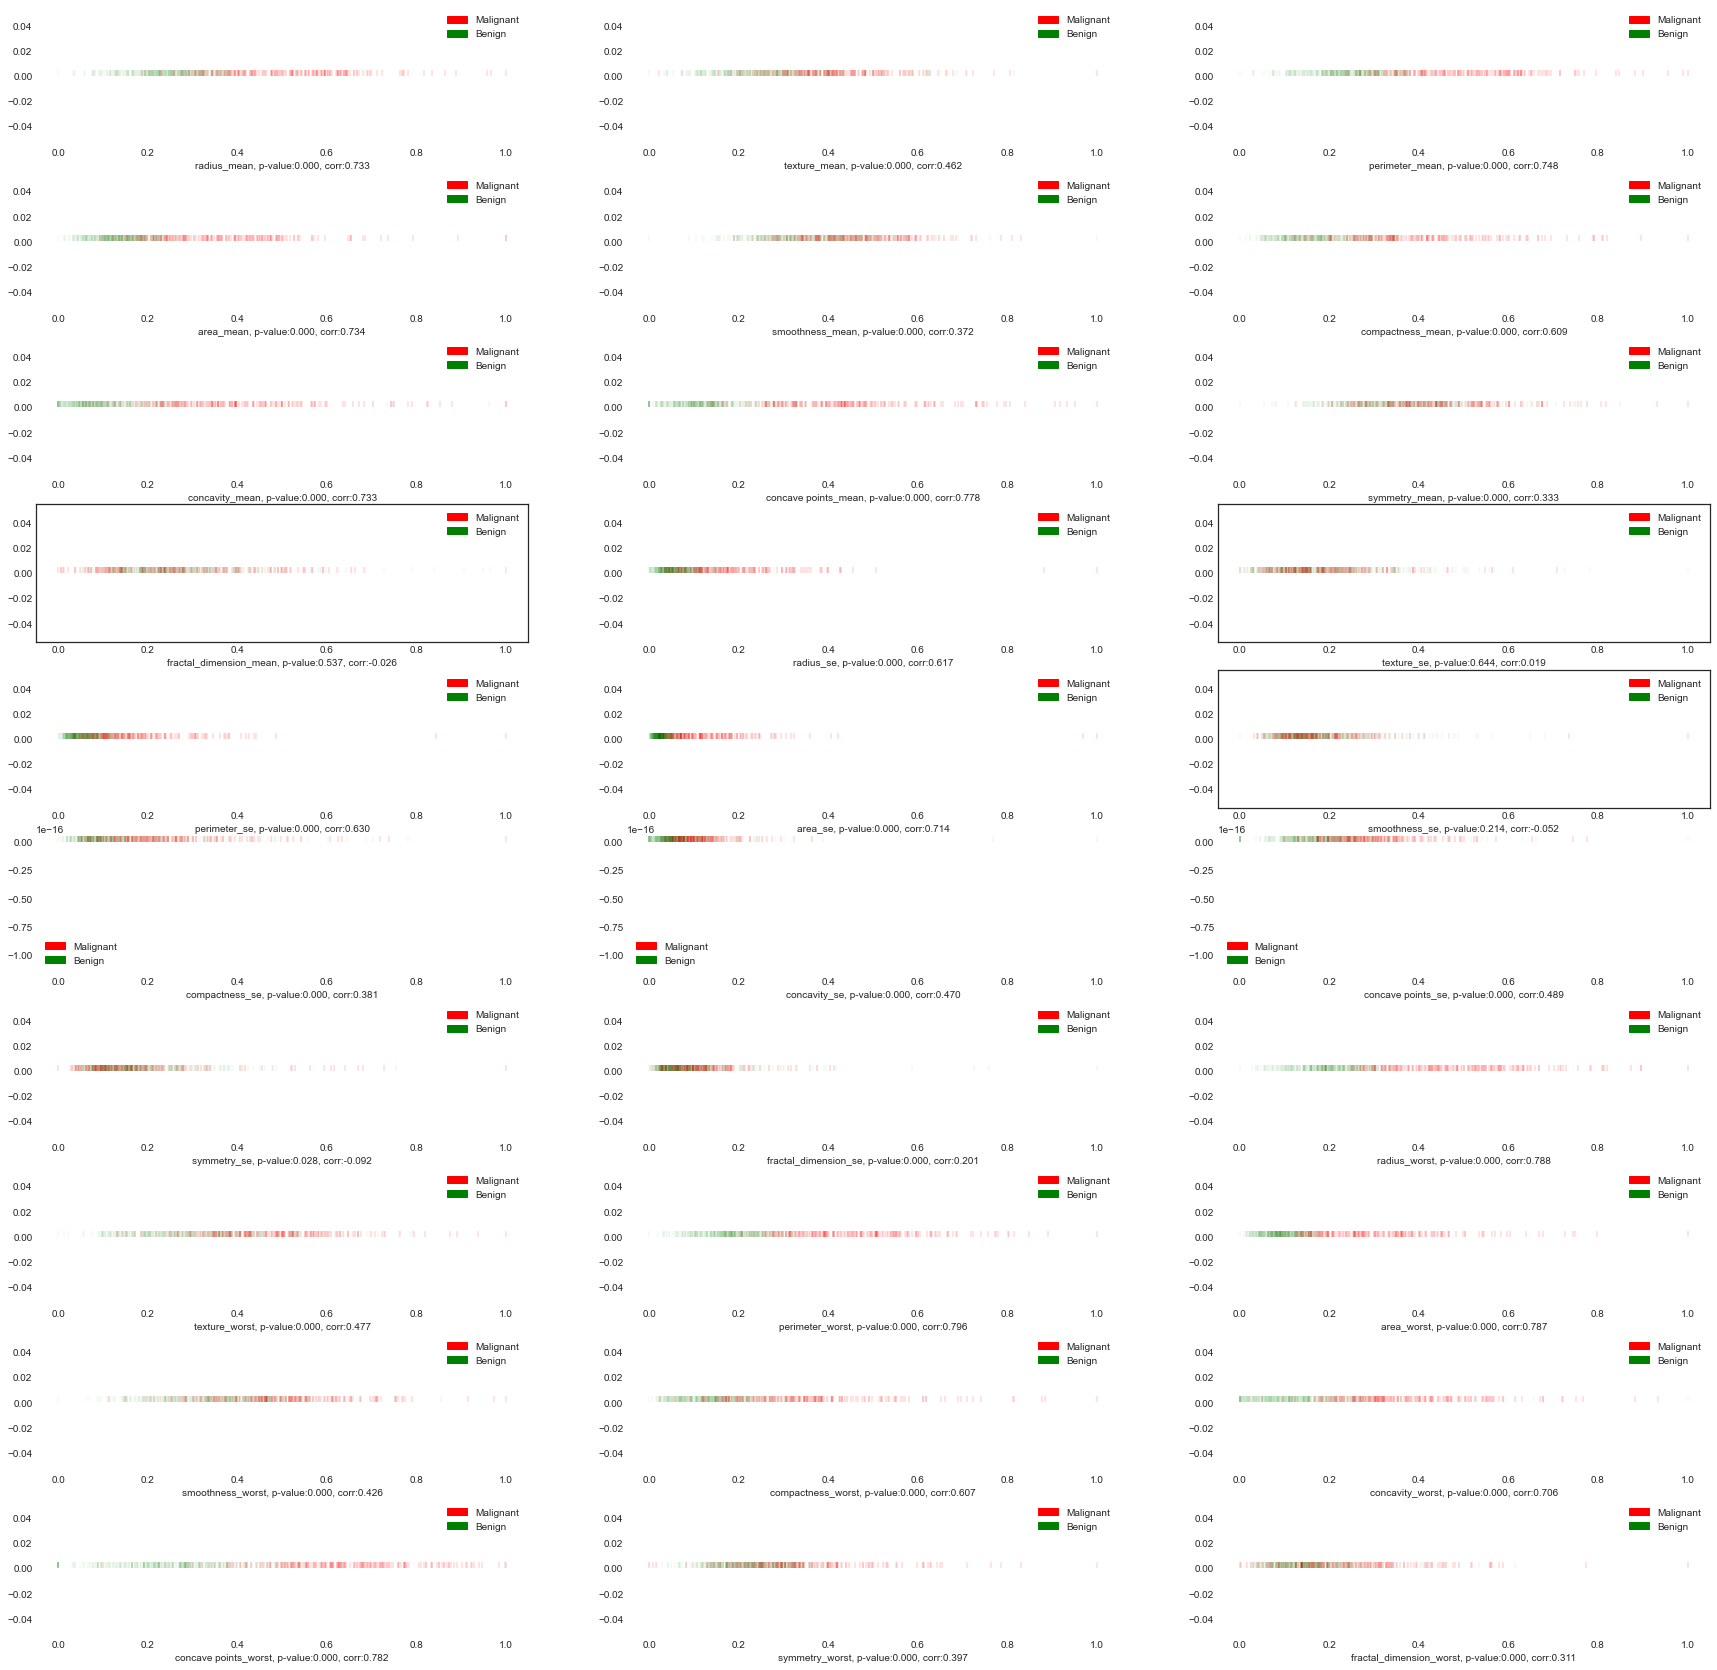

In [46]:
import numpy as np
import scipy
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import matplotlib.markers as mark
import matplotlib.patches as mpatches


prec = 3
sig_lev=0.05
pattern = '{0:.{1}f}'
plt.style.use('seaborn-white')
plt.figure(figsize=(30,30))
size=y.size 
red_patch = mpatches.Patch(color='red', label='Malignant')
green_patch = mpatches.Patch(color='green', label='Benign')
for i in range(0,30):
  current_feature=X[:,i]
  malignant=[]
  benignant=[]
  for f in range(0,size):
    if y[f]>0:
      malignant.append(current_feature[f])
    else:
      benignant.append(current_feature[f])
  corr, p_value = spearmanr(current_feature, y)
  c = pattern.format(corr, prec)
  p = pattern.format(p_value, prec)
  significant = p_value < sig_lev
  subplot = plt.subplot(10,3, i+1)
  subplot.scatter(malignant,[0]*len(malignant), marker=mark.TICKUP,c=("red"),alpha=0.15)
  subplot.scatter(benignant,[0]*len(benignant), marker=mark.TICKUP,c=("green"),alpha=0.05)
  subplot.set_xlabel(br_head[i+1] + ', p-value:'+p+ ', corr:'+c)
  
  subplot.legend(handles=[red_patch, green_patch])
  if(significant):
    subplot.set_frame_on(False)

The graphics above show the combination of malignant and benignant results for each measure. The more separated the colors the more correlated.
The three graphics with less relevant features are framed.
As a result we can conclude that almost all the features independently can explain at some extent the dependent variable, diagnose, except 3 features:

*   fractal_dimension_mean
*   texture_se
*   smoothness_se

## Evaluating if the dataset is linearly separable

### Should we use SVM to check linear separability?
Using SVMs is a sub-optimal solution to verifying linear separability for two reasons:

1. SVMs are soft-margin classifiers. That means a linear kernel SVM might settle for a separating plane which is not separating perfectly even though it might be actually possible. If you then check the error rate it is going to be not 0 and you will falsely conclude that the two sets are not linearly separable. **This issue can be attenuated by choosing a very high cost coefficient C - although this comes itself at a very high computational cost**.

2. SVMs are maximum-margin classifiers. That means the algorithm will try to find a separating plane that is separating the two classes while trying to stay away from both as far as possible. Again this is a feature increasing the computational effort unnecessarily as it calculates something that is not relevant to answering the question of linear separability.

Despite mentioned before, we will try:
* Instantiate a SVM with a big C hyperparameter.
* Train the model with all our data.
* Classify the dataset with our newly trained SVM.
* If we get 100% accuracy on classification, we will conclude that our data is linearly separable (if not, we __cannot conclude__ that our data is not linearly separable).

**Important note**: *To check if data is linearly separable we are not using cross validation. We just fit our model to entire data and check the error, there is no need for train/validation/test splits: __train on everything - test on everything__. In fact doing cross validation makes it wrong, since we could get 100% without linear separability (as long as we were lucky enough to split data in such a way that each testing subset is linearly separable).*

In [47]:
from sklearn import svm

clf = svm.SVC(C=100000.0, kernel='linear')
clf.fit(X, y)

SVC(C=100000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [48]:
p = clf.predict(X)

In [49]:
(p == y).all()

False

We have obtained an error rate not equal to 0, but we cannot conclude that our data is not linearly separable (see point 1 above). So now we try the same as before, but with __Logisic Regression__:
* Instantiate a Logistic Regression with a big C hyperparameter.
* Train the model with all our data.
* Classify the dataset with our newly trained Logistic Regression.
* If we get 100% accuracy on classification, our data is linearly separable. If not, we couldn't conclude with a 100% of accuracy that our data is not linearly separable, but we could settle for that since we would have obtained enough signs.

In [50]:
from sklearn import linear_model

clf = linear_model.LogisticRegression(C=100000.0, solver='liblinear')
clf.fit(X, y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
p = clf.predict(X)

In [52]:
(p == y).all()

False

Effectively, we haven't got 100% of accuracy with Logistic Regression. In any case, from now on, given the previous clues, we will consider that our data is not linearly separable.

## Support Vector Machine

Main advantage regarding our dataset:
- It is effective in high dimensional spaces

Main disadvantage:
- It does not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation

In [53]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X.shape, y.shape

((569, 30), (569,))

We sample a training set while holding out 40% of the data for testing (evaluating) our classifier:

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [55]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((341, 30), (341,), (228, 30), (228,))

### SVM with linear kernel

In [56]:
# We fit the model BEFORE doing cross-validation.
# We do cross-validation over the training set. Does it make sense?

clf = svm.SVC(kernel='linear').fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Score for each run of the cross validation: ", scores)
# The mean score and the 95% confidence interval of the score estimate are hence given by:
print(">> Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
score = clf.score(X_test, y_test)
print("Mean accuracy on the test data and labels: ", score)

Score for each run of the cross validation:  [0.97101449 0.94117647 0.95588235 0.97058824 1.        ]
>> Accuracy: 0.97 (+/- 0.04)
Mean accuracy on the test data and labels:  0.9649122807017544


In [57]:
yhat = clf.predict(X_test)

In [58]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
print("Jaccard index: %.2f" % jaccard_score(y_test, yhat))
print("F1-score: %.2f" % f1_score(y_test, yhat, average='weighted') )

Jaccard index: 0.90
F1-score: 0.96


### SVM with polynomial kernel, degree 2, 3, 4 and 5

In [59]:
for i in [2, 3, 4, 5]:
  clf = svm.SVC(kernel='poly',degree=i).fit(X_train, y_train)
  yhat = clf.predict(X_test)

  print("\nPolynomial kernel, degree = ", i)
  scores = cross_val_score(clf, X_train, y_train, cv=5)
  print("Score for each run of the cross validation: ", scores)
  # The mean score and the 95% confidence interval of the score estimate are hence given by:
  print(">> Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  score = clf.score(X_test, y_test)
  print("Mean accuracy on the test data and labels: ", score)
  print("Jaccard index: %.2f" % jaccard_score(y_test, yhat))
  print("F1-score: %.2f" % f1_score(y_test, yhat, average='weighted') )


Polynomial kernel, degree =  2
Score for each run of the cross validation:  [0.97101449 0.94117647 0.98529412 1.         1.        ]
>> Accuracy: 0.98 (+/- 0.04)
Mean accuracy on the test data and labels:  0.9736842105263158
Jaccard index: 0.93
F1-score: 0.97

Polynomial kernel, degree =  3
Score for each run of the cross validation:  [0.97101449 0.94117647 0.98529412 1.         1.        ]
>> Accuracy: 0.98 (+/- 0.04)
Mean accuracy on the test data and labels:  0.9736842105263158
Jaccard index: 0.93
F1-score: 0.97

Polynomial kernel, degree =  4
Score for each run of the cross validation:  [0.97101449 0.92647059 0.97058824 0.98529412 1.        ]
>> Accuracy: 0.97 (+/- 0.05)
Mean accuracy on the test data and labels:  0.956140350877193
Jaccard index: 0.88
F1-score: 0.96

Polynomial kernel, degree =  5
Score for each run of the cross validation:  [0.94202899 0.92647059 0.94117647 0.97058824 0.95588235]
>> Accuracy: 0.95 (+/- 0.03)
Mean accuracy on the test data and labels:  0.956140350

### SVM with RBF kernel

In [60]:
clf = svm.SVC(kernel='rbf').fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Score for each run of the cross validation: ", scores)
# The mean score and the 95% confidence interval of the score estimate are hence given by:
print(">> Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
score = clf.score(X_test, y_test)
print("Mean accuracy on the test data and labels: ", score)

Score for each run of the cross validation:  [0.97101449 0.94117647 0.95588235 0.98529412 1.        ]
>> Accuracy: 0.97 (+/- 0.04)
Mean accuracy on the test data and labels:  0.9736842105263158


In [61]:
yhat = clf.predict(X_test)

In [62]:
print("Jaccard index: %.2f" % jaccard_score(y_test, yhat))
print("F1-score: %.2f" % f1_score(y_test, yhat, average='weighted') )

Jaccard index: 0.93
F1-score: 0.97


### SVM with sigmoid kernel

In [63]:
clf = svm.SVC(kernel='sigmoid', C=1).fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Score for each run of the cross validation: ", scores)
# The mean score and the 95% confidence interval of the score estimate are hence given by:
print(">> Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
score = clf.score(X_test, y_test)
print("Mean accuracy on the test data and labels: ", score)

Score for each run of the cross validation:  [0.24637681 0.39705882 0.32352941 0.27941176 0.36764706]
>> Accuracy: 0.32 (+/- 0.11)
Mean accuracy on the test data and labels:  0.2894736842105263


In [64]:
yhat = clf.predict(X_test)
print("Jaccard index: %.2f" % jaccard_score(y_test, yhat))
print("F1-score: %.2f" % f1_score(y_test, yhat, average='weighted') )

Jaccard index: 0.01
F1-score: 0.29


## MLP
Multilayer perceptron is a neural network consisting in a minimum of three layers, input layer, output layer and a minimum of one hidden layer.
In MLPs some neurons use a nonlinear activation function that was developed to model the frequency of action potentials, or firing, of biological neurons.
This methop when using a non linear activation funtion between nodes provides classificatio for non linear separated data.


### MLP with adam solver

In [65]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier(hidden_layer_sizes=(100,),
                           max_iter=10000,
                           activation = 'tanh',
                           solver='adam',
                           random_state=1)
#https://analyticsindiamag.com/a-beginners-guide-to-scikit-learns-mlpclassifier/
#Fitting the training data to the network
classifier.fit(X_train, y_train)

print("Accuracy of MLPClassifier : ", classifier.score(X_test, y_test))

Accuracy of MLPClassifier :  0.9736842105263158


In [66]:
scores = cross_val_score(classifier, X_train, y_train, cv=5)
print("Score for each run of the cross validation: ", scores)
# The mean score and the 95% confidence interval of the score estimate are hence given by:
print(">> Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
score = classifier.score(X_test, y_test)
print("Mean accuracy on the test data and labels: ", score)

Score for each run of the cross validation:  [0.95652174 0.92647059 0.97058824 1.         0.98529412]
>> Accuracy: 0.97 (+/- 0.05)
Mean accuracy on the test data and labels:  0.9736842105263158


In [67]:
yhat = classifier.predict(X_test)
print("Jaccard index: %.2f" % jaccard_score(y_test, yhat))
print("F1-score: %.2f" % f1_score(y_test, yhat, average='weighted') )

Jaccard index: 0.93
F1-score: 0.97


### MLP with sgd solver

In [68]:
classifier = MLPClassifier(max_iter=10000,
                           activation = 'relu',
                           solver='sgd',
                           learning_rate='adaptive',
                           random_state=1)
classifier.fit(X_train, y_train)
print("Accuracy of MLPClassifier : ", classifier.score(X_test, y_test))
scores = cross_val_score(classifier, X_train, y_train, cv=5)
print("Score for each run of the cross validation: ", scores)
# The mean score and the 95% confidence interval of the score estimate are hence given by:
print(">> Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
score = classifier.score(X_test, y_test)
print("Mean accuracy on the test data and labels: ", score)

Accuracy of MLPClassifier :  0.9298245614035088
Score for each run of the cross validation:  [0.95652174 0.94117647 0.94117647 0.95588235 1.        ]
>> Accuracy: 0.96 (+/- 0.04)
Mean accuracy on the test data and labels:  0.9298245614035088


In [69]:
yhat = classifier.predict(X_test)
print("Jaccard index: %.2f" % jaccard_score(y_test, yhat))
print("F1-score: %.2f" % f1_score(y_test, yhat, average='weighted') )

Jaccard index: 0.82
F1-score: 0.93


##  K Nearest Neighbor (KNN)

In [70]:
from sklearn.neighbors import KNeighborsClassifier
k = 3 # number of neighbors

classifier = KNeighborsClassifier(n_neighbors=k)
classifier.fit(X_train,y_train)
print("Accuracy of MLPClassifier : ", classifier.score(X_test, y_test))
scores = cross_val_score(classifier, X_train, y_train, cv=5)
print("Score for each run of the cross validation: ", scores)

# The mean score and the 95% confidence interval of the score estimate are hence given by:
print(">> Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
score = classifier.score(X_test, y_test)
print("Mean accuracy on the test data and labels: ", score)

yhat = classifier.predict(X_test)
print("\nJaccard index: %.2f" % jaccard_score(y_test, yhat))
print("F1-score: %.2f" % f1_score(y_test, yhat, average='weighted') )

Accuracy of MLPClassifier :  0.9649122807017544
Score for each run of the cross validation:  [0.97101449 0.94117647 0.95588235 0.97058824 0.95588235]
>> Accuracy: 0.96 (+/- 0.02)
Mean accuracy on the test data and labels:  0.9649122807017544

Jaccard index: 0.91
F1-score: 0.96


### Finding the best K for KNN

In [71]:
Ks = 10
jac = np.zeros(Ks)
f1 = np.zeros(Ks)
mcv = np.zeros(Ks)
mt = np.zeros(Ks)

for n in range(Ks):
    kNN_model = KNeighborsClassifier(n_neighbors=n+1)
    kNN_model.fit(X_train,y_train)
    yhat = kNN_model.predict(X_test)
    scores = cross_val_score(kNN_model, X_train, y_train, cv=5)
    mcv[n] = scores.mean()
    score = kNN_model.score(X_test, y_test)
    mt[n] = score
    jac[n] = jaccard_score(y_test, yhat)
    f1[n] = f1_score(y_test, yhat, average='weighted')
    
print("Mean accuracy on test data reaches the highest value for", int(np.where(mt == max(mt))[0])+1, "neighbors")
print("Mean accuracy on cv reaches the highest value for", int(np.where(mcv == max(mcv))[0])+1, "neighbors")
print("Jaccard index reaches the highest value for", int(np.where(jac == max(jac))[0])+1, "neighbors")
print("F1-score reaches the highest value for", int(np.where(f1 == max(f1))[0])+1, "neighbors")

Mean accuracy on test data reaches the highest value for 3 neighbors
Mean accuracy on cv reaches the highest value for 10 neighbors
Jaccard index reaches the highest value for 3 neighbors
F1-score reaches the highest value for 3 neighbors


## Decision Trees

In [72]:
from sklearn.tree import DecisionTreeClassifier
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DT_model.fit(X_train,y_train)

scores = cross_val_score(DT_model, X_train, y_train, cv=5)
print("Score for each run of the cross validation: ", scores)

# The mean score and the 95% confidence interval of the score estimate are hence given by:
print(">> Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
score = DT_model.score(X_test, y_test)
print("Mean accuracy on the test data and labels: ", score)

yhat = DT_model.predict(X_test)
print("\nJaccard index: %.2f" % jaccard_score(y_test, yhat))
print("F1-score: %.2f" % f1_score(y_test, yhat, average='weighted') )

Score for each run of the cross validation:  [0.89855072 0.88235294 0.91176471 0.97058824 0.86764706]
>> Accuracy: 0.91 (+/- 0.07)
Mean accuracy on the test data and labels:  0.9473684210526315

Jaccard index: 0.86
F1-score: 0.95


## Logistic Regression

In [73]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression()
LR_model.fit(X_train,y_train)

scores = cross_val_score(LR_model, X_train, y_train, cv=5)
print("Score for each run of the cross validation: ", scores)

# The mean score and the 95% confidence interval of the score estimate are hence given by:
print(">> Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
score = DT_model.score(X_test, y_test)
print("Mean accuracy on the test data and labels: ", score)

yhat = LR_model.predict(X_test)
print("\nJaccard index: %.2f" % jaccard_score(y_test, yhat))
print("F1-score: %.2f" % f1_score(y_test, yhat, average='weighted') )

Score for each run of the cross validation:  [0.97101449 0.94117647 0.94117647 0.95588235 0.98529412]
>> Accuracy: 0.96 (+/- 0.03)
Mean accuracy on the test data and labels:  0.9473684210526315

Jaccard index: 0.86
F1-score: 0.95


# Algorithms comparison

| Algorithm | Mean accuracy on cross-validation | Accuracy on the test data | Jaccard score | F1-score |
| -------- | --------------------------- | ----------------------- | ------ | ------ |
| SVM linear kernel | 0.97 (+/- 0.04) | 0.96 | 0.90 | 0.96 |
| SVM polynomial kernel (2) | 0.98 (+/- 0.04) | 0.97 | 0.93 | 0.97 |
| SVM polynomial kernel (3) | 0.98 (+/- 0.04) | 0.97 | 0.93 | 0.97 |
| SVM polynomial kernel (4) | 0.97 (+/- 0.05) | 0.96 | 0.88 | 0.96 |
| SVM polynomial kernel (5) | 0.95 (+/- 0.03) | 0.96 | 0.89 | 0.96 |
| SVM RFB kernel | 0.97 (+/- 0.04) | 0.97 | 0.93 | 0.97 |
| SVM sigmoid kernel | 0.32 (+/- 0.11) | 0.29 | 0.01 | 0.29 |
| MLP with adam solver | 0.97 (+/- 0.05) | 0.97 | 0.93 | 0.97 |
| MLP with sgd solver | 0.96 (+/- 0.04) | 0.93 | 0.82 | 0.93 |
| K Nearest Neighbors | 0.96 (+/- 0.02) | 0.96 | 0.91 | 0.96 |
| Decision Tree | 0.91 (+/- 0.07) | 0.95 | 0.86 | 0.95 |
| Logistic Regression | 0.96 (+/- 0.03) | 0.95 | 0.86 | 0.95 |


# Features selection

In [74]:
from sklearn.feature_selection import SelectKBest, RFECV

# Selecting the 27 most relevant features with SelectKBest (based on f_classif score function by default).
# It selects features according to the k highest scores
features = SelectKBest(k=27).fit(X_train, y_train).get_support()

In [75]:
print("Features eliminated by using SelectKBest:")
for (i,j) in zip(br_head, features):
    if not j: print("- ", i)

Features eliminated by using SelectKBest:
-  symmetry_mean
-  area_se
-  concave points_se


In [80]:
# Selecting the most relevant features with RFECV (based on SVM with linear kernel)
# It ranks features by recursive feature elimination and cross-validated selection of the best number of features.
estimator = svm.SVC(kernel="linear")  # Corrected after the presentation. Thanks Giovanni!
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train, y_train)
features = selector.support_
print("Features eliminated by using RFECV:")
for (i,j) in zip(br_head, features):
    if not j: print("- ", i)

Features eliminated by using RFECV:
-  area_mean
-  smoothness_mean
-  radius_se
-  area_se
-  compactness_se
-  concave points_se
-  smoothness_worst


In [77]:
# Selecting the most relevant features with Decision Tree
estimator = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
selector = RFECV(estimator, step=1, cv=5, min_features_to_select=25)
selector = selector.fit(X_train, y_train)
features = selector.support_
print("Features eliminated by using Decision Tree:")
for (i,j) in zip(br_head, features):
    if not j: print("- ", i)

Features eliminated by using Decision Tree:
-  diagnosis
-  area_se
-  smoothness_se
-  symmetry_worst
